In [1]:
# An example plotting script for DCMIP 2025 test case 2a: Gap flow

In [66]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Parameters from the simulation:
rot = False
u0 = 10
T0 = 288
h_val = 1500 # meters
small_earth_fact = 20 
# add mountain params
center_lat = 0
center_lon = np.deg2rad(90)
e1 = 10 # exponent
e2 = 10 # exponent
e3 = 10 # exponent
xlon = 40000 # m
xlat = 300000 # m
xgap = 25000 # m
d1 = xlon / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e1) # scale factors
d2 = xlat / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e2)
d3 = xgap / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e3)

In [4]:
def mountain_shape(lats, lons, z_val): # shape of the mountain
    filter = np.zeros(np.shape(lats))
    gpart = 1.0 - np.exp(-np.power((lats - center_lat)/d3, e3))
    hpart = h_val * np.exp(-np.power((lons - center_lon)/d1, e1) -np.power((lats - center_lat)/d2, e2))
    height = gpart * hpart
    count = 0
    x = np.zeros(np.size(lons))
    y = np.zeros(np.size(lons))
    for j in range(np.size(lon_inds)):
        for i in range(np.size(lat_inds)):
            if (height[i, j] > z_val):
                filter[i, j] = 1.0
                count += 1
                x[count-1] = lons[i, j]
                y[count-1] = lats[i, j]
    return np.rad2deg(x[0:count]), np.rad2deg(y[0:count])

In [15]:
# Information about the paths
model = 'SE' # or 'FV3' or 'MPAS'
vert = 'hydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'cam_6_4_060_horiz_mount_flow_se_ne30_30km_L38'

# Modify the following according to your naming convention
if rot:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_gap_with_rot_RF_15km_tau_1_10th_day.nc'
else:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_gap_omega0_RF_15km_tau_1_10th_day.nc'

# Define the base root to the data,
# add your username
username = 'timand'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [6]:
# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
output_dir = f'{CAM_dirname}/plotting/'
output_file = output_base + output_dir

In [60]:
# Extract the data
nc = Dataset(run_path)
time = nc['time'][:]
lat = nc['lat'][:] 
lon = nc['lon'][:] 
lev = nc['lev'][:]

print(f'There are {len(time)} time samples')
print(f'{len(lat)} latitiude points, {len(lon)} longitude points')

There are 41 time samples
257 latitiude points, 512 longitude points


In [69]:
# Specify the altitude, field and times you want to plot
z_val = 300 # in metres
field = 'div' # or U or V or W or div or vor
t_idxs = [10,20,30,40] # Each index is 0.25 small Earth hours

In [70]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 170.
lon_ticks = np.linspace(80, 160, 6) # Plotting ticks

lat_crop_up = 50.
lat_crop_down = -50.
lat_ticks = np.linspace(-40,40,5) # Plotting ticks

lon_inds = np.where((lon > lon_crop_left) & (lon < lon_crop_right))[0]
lat_inds = np.where((lat > lat_crop_down) & (lat < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lat[lat_inds] 
lon_slice = lon[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)
mountain_x, mountain_y = mountain_shape(np.deg2rad(LAT_subset), np.deg2rad(LON_subset), z_val)

Crop is of size, 143 lat vals and 142 lon vals


In [71]:
# Interpolate the data at each time index:
if (field == "vor" or field == "div"):
    uv = np.zeros((len(t_idxs), 2, len(lat_slice), len(lon_slice)))
    for i in range(len(t_idxs)):
        uv[i] = z_interp_uv(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['U'][t_idxs[i], :, lat_inds, lon_inds], nc['V'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
        print('interpolated time ' + str(i+1))
elif (field == "W"):
    interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
    if (model == 'MPAS'):
        for i in range(len(t_idxs)): # still needs to be tested
            interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['w'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
    else:
        if (vert == 'hydrostatic'):
            for i in range(len(t_idxs)):
                interp_field_vals[i] = z_interp_w_hydrostatic(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                print('interpolated time ' + str(i+1))
        # else: 
            # under construction
else:
    interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
    for i in range(len(t_idxs)):
        interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc[field][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
        print('interpolated time ' + str(i+1))

interpolated time 1
interpolated time 2
interpolated time 3
interpolated time 4


In [72]:
# process the data, pack the values
if field == 'U':
    # Normalised wind perturbation
    LAT_subset_rad = np.deg2rad(LAT_subset)
    field_vals = (interp_field_vals - u0*np.cos(LAT_subset_rad)) / (u0*np.cos(LAT_subset_rad))
elif field == 'T':
    # temperature perturbation
    field_vals = interp_field_vals - T0
elif field == 'V':
    field_vals = interp_field_vals
elif field == 'W':
    field_vals = interp_field_vals
elif field == "vor":
    # compute vorticity
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.vorticity(uv_ds['U'], uv_ds['V'])
elif field == "div":
    # compute divergence
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.divergence(uv_ds['U'], uv_ds['V'])

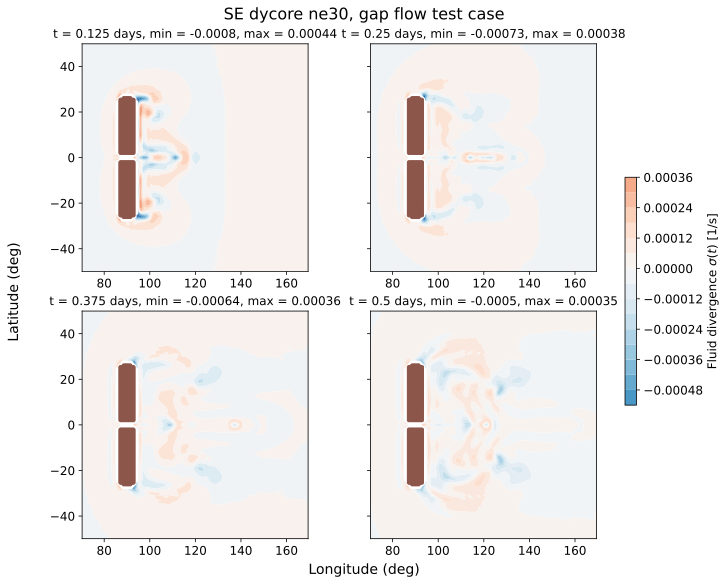

In [77]:
# Make the plot!
fig, axes = plt.subplots(2,2,figsize = (10,8), sharey=True, layout="constrained") # first 2 is horizontal count, second is vertical count

title_size=16
label_size=14
small_size=12

round_dig = 2

# For the title
dycore_res = 'SE ne60'

# for the color map
norm = MidpointNormalize(midpoint = 0)
cmap_choice = 'RdBu_r'
levels = 15

fix_minmax = False # modify the min/max values after visualizing without the fixed limits

if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min = -9
    max = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min = -0.2
    max = 0.36
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 5
    min = -0.00014*small_earth_fact
    max = 0.00016*small_earth_fact
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 5
    min = -0.00003*small_earth_fact
    max = 0.00003*small_earth_fact

if fix_minmax:
    levels = np.mgrid[min:max:levels*1j]
    
for ind, ax in enumerate(np.ravel(axes)):
    plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time[t_idxs[ind]]} days, min = {np.round(np.nanmin(field_vals[ind]),round_dig)}, max = {np.round(np.nanmax(field_vals[ind]),round_dig)}', size=small_size)
    ax.scatter(mountain_x, mountain_y, color='tab:brown', s=12, marker='o')

cb = plt.colorbar(plot, ax=axes, fraction=0.02)
cb.set_label(label=title + ' '  + cb_label, size=small_size)
cb.ax.tick_params(labelsize=12)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle('SE dycore ne30, gap flow test case', size=title_size)
plt.show()